In [ ]:
import pandas as pd
import numpy as np
import random
import glob
import tempfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim, Tensor
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary
import timm
import torchvision
from torchvision import transforms, datasets, models
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
train = pd.read_csv(r"/kaggle/input/UBC-OCEAN/train.csv")
test = pd.read_csv(r"/kaggle/input/UBC-OCEAN/test.csv")
train_tma = train[train["is_tma"] == True]
train_no_tma = train[train["is_tma"] == False]

In [ ]:
train_tma['img_id_ext']=[str(i)+".png" for i in train_tma['image_id']]
train_no_tma['img_id_ext']=[str(i)+"_thumbnail.png" for i in train_no_tma['image_id']]
test['img_id_ext']=[str(i)+"_thumbnail.png" for i in test['image_id']]

/tmp/ipykernel_47/427597629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tma['img_id_ext']=[str(i)+".png" for i in train_tma['image_id']]
/tmp/ipykernel_47/427597629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_tma['img_id_ext']=[str(i)+"_thumbnail.png" for i in train_no_tma['image_id']]


In [ ]:
train_df = pd.concat([train_tma, train_no_tma])
train_df.sort_index(ascending = True, inplace = True)
train_df.head()

,image_id,label,image_width,image_height,is_tma,img_id_ext
0,4,HGSC,23785,20008,False,4_thumbnail.png
1,66,LGSC,48871,48195,False,66_thumbnail.png
2,91,HGSC,3388,3388,True,91.png
3,281,LGSC,42309,15545,False,281_thumbnail.png
4,286,EC,37204,30020,False,286_thumbnail.png


In [ ]:
le = LabelEncoder()
image_label = train_df['label']
le.fit(image_label)
train_df['label'] = le.transform(image_label)
train_df.head()

,image_id,label,image_width,image_height,is_tma,img_id_ext
0,4,2,23785,20008,False,4_thumbnail.png
1,66,3,48871,48195,False,66_thumbnail.png
2,91,2,3388,3388,True,91.png
3,281,3,42309,15545,False,281_thumbnail.png
4,286,1,37204,30020,False,286_thumbnail.png


In [ ]:
test

,image_id,image_width,image_height,img_id_ext
0,41,28469,16987,41_thumbnail.png


In [ ]:
test.iloc[0, 0]

41

In [ ]:
import os
class TrainDataset(Dataset):
    def __init__(self, df, root_path, train_thumbnails, train_images, transform=None):
        self.df = df
        self.root_path = root_path
        self.train_thumbnails = train_thumbnails
        self.train_images = train_images
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, -1]

        if "thumbnail" in img_name:
            img_path = os.path.join(root_path + train_thumbnails, img_name)
        else:
            img_path = os.path.join(root_path + train_images, img_name)

        img = Image.open(img_path).convert('RGB')


        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx, 1]
        label = torch.tensor(label)
        return img, label


norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomCrop(128, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

root_path = "/kaggle/input/UBC-OCEAN/"
train_thumbnails = "train_thumbnails/"
train_images = "train_images/"
test_thumbnails = "test_thumbnails/"
test_images = "test_images/"

dataset = TrainDataset(df=train_df, root_path = root_path, train_thumbnails = train_thumbnails, train_images = train_images, transform=train_transform)

train_ratio = 0.8
valid_ratio = 0.2

train_size = int(train_ratio * len(train_df))
valid_size = len(train_df) - train_size

dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])

train_dataloader = DataLoader(dataset_train, batch_size = 64, shuffle = True)
valid_dataloader = DataLoader(dataset_valid, batch_size = 64, shuffle = True)

dataiter = iter(train_dataloader)
images = next(dataiter)
images[0].shape

torch.Size([64, 3, 128, 128])

In [ ]:
def show_pic(dataloader):
    examples = enumerate(dataloader)
    batch_idx, (example_data, example_targets) = next(examples)
    classes = ('HGSC', 'LGSC', 'EC', 'CC', 'MC')
    fig = plt.figure()
    for i in range(5):
        plt.subplot(2, 3, i + 1)
        img = example_data[i]
        print('pic shape:',img.shape)
        img = img.swapaxes(0, 1)
        img = img.swapaxes(1, 2)
        plt.imshow(img, interpolation='none')
        plt.title(classes[example_targets[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
def build_model(num_classes, model_type = "resnet50", freeze_convnets = False, single_layer = True, hidden_units = 32):
    if model_type =="resnet50":
        model = models.resnet50(pretrained = True)

    if freeze_convnets:
        for param in model.parameters():
            param.requires_gradd = False

    num_ftrs = model.fc.in_features

    if single_layer:
        model.fc = nn.Linear(num_ftrs, num_classes)
    else:
        model.fc = nn.Sequential(
                    nn.Linear(num_ftrs, hidden_units),
                    nn.ReLU(),
                    nn.Linear(hidden_units, num_classes)
                )
    return model

In [ ]:
def train(net, loss, train_dataloader, valid_dataloader, device, batch_size, num_epoch, lr, lr_min, optim='adamW', init=True, scheduler_type='Cosine'):
    def init_xavier(m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)

    if init:
        net.apply(init_xavier)

    print('training on:', device)
    net.to(device)

    if optim == 'adamW':
        optimizer = torch.optim.AdamW((param for param in net.parameters() if param.requires_grad), lr=lr,
                                      weight_decay=0)
    if scheduler_type == 'Cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=lr_min)

    train_losses = []
    train_acces = []
    eval_acces = []
    eval_precisions = []
    eval_recalls = []
    eval_accuracies = []
    best_acc = 0.0

    for epoch in range(num_epoch):

        print("——————Start of training round {}——————".format(epoch + 1))


        net.train()
        train_acc = 0
        for batch in tqdm(train_dataloader, desc='Train'):
            imgs, targets = batch
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = net(imgs)

            Loss = loss(output, targets)

            optimizer.zero_grad()
            Loss.backward()
            optimizer.step()

            _, pred = output.max(1)
            num_correct = (pred == targets).sum().item()
            acc = num_correct / (batch_size)
            train_acc += acc

        scheduler.step()
        print("epoch: {}, Loss: {}, Acc: {}".format(epoch, Loss.item(), train_acc / len(train_dataloader)))
        train_acces.append(train_acc / len(train_dataloader))
        train_losses.append(Loss.item())


        net.eval()
        eval_loss = 0
        eval_acc = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for imgs, targets in valid_dataloader:
                imgs = imgs.to(device)
                targets = targets.to(device)
                output = net(imgs)
                Loss = loss(output, targets)
                _, pred = output.max(1)
                num_correct = (pred == targets).sum().item()
                eval_loss += Loss
                acc = num_correct / imgs.shape[0]
                eval_acc += acc

                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

            eval_losses = eval_loss / (len(valid_dataloader))
            eval_acc = eval_acc / (len(valid_dataloader))
            eval_acces.append(eval_acc)

            accuracy = accuracy_score(all_targets, all_preds)
            precision = precision_score(all_targets, all_preds, average='weighted')
            recall = recall_score(all_targets, all_preds, average='weighted')

            eval_accuracies.append(accuracy)
            eval_precisions.append(precision)
            eval_recalls.append(recall)

            if eval_acc > best_acc:
                best_acc = eval_acc
                torch.save(net.state_dict(), 'best_acc.pth')

            print("Loss on the overall validation set: {}".format(eval_losses))
            print("Correctness on the overall validation set: {}".format(eval_acc))
            print("Accuracy: {}, Precision: {}, Recall: {}".format(accuracy, precision, recall))

    return train_losses, train_acces, eval_acces, eval_accuracies, eval_precisions, eval_recalls

In [ ]:
def show_acces(train_losses, train_acces, valid_acces, num_epoch):
    plt.plot(1 + np.arange(len(train_losses)), train_losses, linewidth=1.5, linestyle='dashed', label='train_losses')
    plt.plot(1 + np.arange(len(train_acces)), train_acces, linewidth=1.5, linestyle='dashed', label='train_acces')
    plt.plot(1 + np.arange(len(eval_acces)), eval_acces, linewidth=1.5, linestyle='dashed', label='eval_acces')
    plt.grid()
    plt.xlabel('epoch')
    plt.xticks(range(1, 1 + num_epoch, 1))
    plt.legend()
    plt.show()

pic shape: torch.Size([3, 128, 128])
pic shape: torch.Size([3, 128, 128])
pic shape: torch.Size([3, 128, 128])
pic shape: torch.Size([3, 128, 128])
pic shape: torch.Size([3, 128, 128])


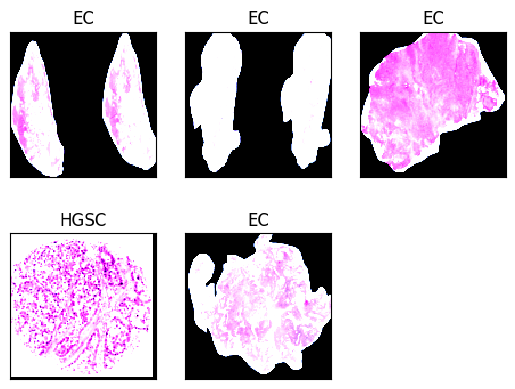

In [ ]:
show_pic(train_dataloader)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
net = build_model(num_classes = 5, model_type = "resnet50", freeze_convnets = False, single_layer = True, hidden_units = 64)

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
train_losses, train_acces, eval_acces, eval_accuracies, eval_precisions, eval_recalls = train(net, loss, train_dataloader, valid_dataloader, device, batch_size=64, num_epoch=20, lr=0.001, lr_min=1e-4, optim='adamW', init=False)

training on: cpu
——————Start of training round 1——————


Train: 100%|██████████| 7/7 [02:51<00:00, 24.45s/it]


epoch: 0, Loss: 1.4041048288345337, Acc: 0.3236607142857143


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on the overall validation set: 6.575848579406738
Correctness on the overall validation set: 0.2663352272727273
Accuracy: 0.2777777777777778, Precision: 0.0778816199376947, Recall: 0.2777777777777778
——————Start of training round 2——————


Train: 100%|██████████| 7/7 [02:47<00:00, 23.98s/it]


epoch: 1, Loss: 1.3561718463897705, Acc: 0.42410714285714285
Loss on the overall validation set: 22.923648834228516
Correctness on the overall validation set: 0.265625
Accuracy: 0.26851851851851855, Precision: 0.31240981240981247, Recall: 0.26851851851851855
——————Start of training round 3——————


Train: 100%|██████████| 7/7 [02:37<00:00, 22.50s/it]


epoch: 2, Loss: 1.211297631263733, Acc: 0.47767857142857145


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on the overall validation set: 6.405421257019043
Correctness on the overall validation set: 0.3884943181818182
Accuracy: 0.3888888888888889, Precision: 0.4779108309990662, Recall: 0.3888888888888889
——————Start of training round 4——————


Train: 100%|██████████| 7/7 [02:24<00:00, 20.62s/it]


epoch: 3, Loss: 0.9244840145111084, Acc: 0.5647321428571429


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on the overall validation set: 2.0730063915252686
Correctness on the overall validation set: 0.4005681818181818
Accuracy: 0.4074074074074074, Precision: 0.41047307812013695, Recall: 0.4074074074074074
——————Start of training round 5——————


Train: 100%|██████████| 7/7 [02:33<00:00, 21.88s/it]


epoch: 4, Loss: 0.69685298204422, Acc: 0.59375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on the overall validation set: 1.1798597574234009
Correctness on the overall validation set: 0.5454545454545454
Accuracy: 0.5370370370370371, Precision: 0.5134991450780925, Recall: 0.5370370370370371
——————Start of training round 6——————


Train: 100%|██████████| 7/7 [02:33<00:00, 21.99s/it]


epoch: 5, Loss: 0.9134038686752319, Acc: 0.6785714285714286
Loss on the overall validation set: 1.6655173301696777
Correctness on the overall validation set: 0.43394886363636365
Accuracy: 0.42592592592592593, Precision: 0.4836459836459837, Recall: 0.42592592592592593
——————Start of training round 7——————


Train: 100%|██████████| 7/7 [02:26<00:00, 20.89s/it]


epoch: 6, Loss: 0.4887079894542694, Acc: 0.765625
Loss on the overall validation set: 2.288262128829956
Correctness on the overall validation set: 0.4140625
Accuracy: 0.39814814814814814, Precision: 0.4603653427182839, Recall: 0.39814814814814814
——————Start of training round 8——————


Train: 100%|██████████| 7/7 [02:26<00:00, 20.91s/it]


epoch: 7, Loss: 0.5993751883506775, Acc: 0.7790178571428571
Loss on the overall validation set: 1.6255714893341064
Correctness on the overall validation set: 0.4545454545454546
Accuracy: 0.46296296296296297, Precision: 0.4468956879584899, Recall: 0.46296296296296297
——————Start of training round 9——————


Train: 100%|██████████| 7/7 [02:25<00:00, 20.83s/it]


epoch: 8, Loss: 0.3097596764564514, Acc: 0.8504464285714286
Loss on the overall validation set: 1.9500575065612793
Correctness on the overall validation set: 0.5177556818181819
Accuracy: 0.5, Precision: 0.4546031746031746, Recall: 0.5
——————Start of training round 10——————


Train: 100%|██████████| 7/7 [02:26<00:00, 20.86s/it]


epoch: 9, Loss: 0.9948028326034546, Acc: 0.8482142857142857
Loss on the overall validation set: 1.8234357833862305
Correctness on the overall validation set: 0.5454545454545454
Accuracy: 0.5370370370370371, Precision: 0.5277269219242302, Recall: 0.5370370370370371
——————Start of training round 11——————


Train: 100%|██████████| 7/7 [02:25<00:00, 20.83s/it]


epoch: 10, Loss: 0.4242289066314697, Acc: 0.8325892857142857
Loss on the overall validation set: 1.9752403497695923
Correctness on the overall validation set: 0.4375
Accuracy: 0.42592592592592593, Precision: 0.45551864156515326, Recall: 0.42592592592592593
——————Start of training round 12——————


Train: 100%|██████████| 7/7 [02:24<00:00, 20.58s/it]


epoch: 11, Loss: 0.4101991355419159, Acc: 0.8705357142857143
Loss on the overall validation set: 1.7268426418304443
Correctness on the overall validation set: 0.41903409090909094
Accuracy: 0.4166666666666667, Precision: 0.4432588916459885, Recall: 0.4166666666666667
——————Start of training round 13——————


Train: 100%|██████████| 7/7 [02:23<00:00, 20.57s/it]


epoch: 12, Loss: 0.2090490162372589, Acc: 0.9285714285714286
Loss on the overall validation set: 1.8541693687438965
Correctness on the overall validation set: 0.3657670454545454
Accuracy: 0.37037037037037035, Precision: 0.45706018518518515, Recall: 0.37037037037037035
——————Start of training round 14——————


Train: 100%|██████████| 7/7 [02:27<00:00, 21.03s/it]


epoch: 13, Loss: 0.09147678315639496, Acc: 0.9263392857142857
Loss on the overall validation set: 2.062439441680908
Correctness on the overall validation set: 0.41051136363636365
Accuracy: 0.39814814814814814, Precision: 0.4519211519211519, Recall: 0.39814814814814814
——————Start of training round 15——————


Train: 100%|██████████| 7/7 [02:26<00:00, 20.92s/it]


epoch: 14, Loss: 0.06618604063987732, Acc: 0.9464285714285714
Loss on the overall validation set: 1.9575386047363281
Correctness on the overall validation set: 0.5063920454545454
Accuracy: 0.49074074074074076, Precision: 0.5222526266004527, Recall: 0.49074074074074076
——————Start of training round 16——————


Train: 100%|██████████| 7/7 [02:26<00:00, 20.89s/it]


epoch: 15, Loss: 0.06006879732012749, Acc: 0.9508928571428571
Loss on the overall validation set: 2.0371346473693848
Correctness on the overall validation set: 0.5582386363636364
Accuracy: 0.5648148148148148, Precision: 0.5916666666666667, Recall: 0.5648148148148148
——————Start of training round 17——————


Train: 100%|██████████| 7/7 [02:26<00:00, 20.96s/it]


epoch: 16, Loss: 0.09336161613464355, Acc: 0.9508928571428571
Loss on the overall validation set: 2.005394220352173
Correctness on the overall validation set: 0.4779829545454546
Accuracy: 0.49074074074074076, Precision: 0.4898254821641918, Recall: 0.49074074074074076
——————Start of training round 18——————


Train: 100%|██████████| 7/7 [02:24<00:00, 20.69s/it]


epoch: 17, Loss: 0.03601156920194626, Acc: 0.953125
Loss on the overall validation set: 1.9418816566467285
Correctness on the overall validation set: 0.53125
Accuracy: 0.5370370370370371, Precision: 0.52369813422445, Recall: 0.5370370370370371
——————Start of training round 19——————


Train: 100%|██████████| 7/7 [02:23<00:00, 20.53s/it]


epoch: 18, Loss: 0.028859112411737442, Acc: 0.9575892857142857
Loss on the overall validation set: 1.9889240264892578
Correctness on the overall validation set: 0.515625
Accuracy: 0.5185185185185185, Precision: 0.4931752873563218, Recall: 0.5185185185185185
——————Start of training round 20——————


Train: 100%|██████████| 7/7 [02:25<00:00, 20.78s/it]


epoch: 19, Loss: 0.007239889819175005, Acc: 0.9598214285714286
Loss on the overall validation set: 1.99171781539917
Correctness on the overall validation set: 0.4992897727272727
Accuracy: 0.49074074074074076, Precision: 0.4632753447198683, Recall: 0.49074074074074076


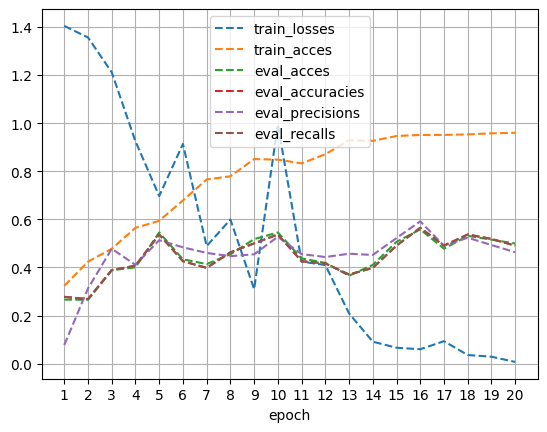

In [ ]:
def show_metrics(train_losses, train_acces, eval_acces, eval_accuracies, eval_precisions, eval_recalls, num_epoch):
    plt.plot(1 + np.arange(len(train_losses)), train_losses, linewidth=1.5, linestyle='dashed', label='train_losses')
    plt.plot(1 + np.arange(len(train_acces)), train_acces, linewidth=1.5, linestyle='dashed', label='train_acces')
    plt.plot(1 + np.arange(len(eval_acces)), eval_acces, linewidth=1.5, linestyle='dashed', label='eval_acces')
    plt.plot(1 + np.arange(len(eval_accuracies)), eval_accuracies, linewidth=1.5, linestyle='dashed', label='eval_accuracies')
    plt.plot(1 + np.arange(len(eval_precisions)), eval_precisions, linewidth=1.5, linestyle='dashed', label='eval_precisions')
    plt.plot(1 + np.arange(len(eval_recalls)), eval_recalls, linewidth=1.5, linestyle='dashed', label='eval_recalls')
    plt.grid()
    plt.xlabel('epoch')
    plt.xticks(range(1, 1 + num_epoch, 1))
    plt.legend()
    plt.show()

show_metrics(train_losses, train_acces, eval_acces, eval_accuracies, eval_precisions, eval_recalls, num_epoch=20)